### Installation

In [1]:
%%capture
import os
if "COLAB_" not in "".join(os.environ.keys()):
    !pip install unsloth
else:
    # Do this only in Colab notebooks! Otherwise use pip install unsloth
    !pip install --no-deps bitsandbytes accelerate xformers==0.0.29.post3 peft trl==0.15.2 triton cut_cross_entropy unsloth_zoo
    !pip install sentencepiece protobuf datasets huggingface_hub hf_transfer
    !pip install --no-deps unsloth

### Unsloth

In [31]:
from unsloth import FastVisionModel # FastLanguageModel for LLMs
import torch

model, tokenizer = FastVisionModel.from_pretrained(
    "unsloth/Qwen2.5-VL-7B-Instruct-bnb-4bit",
    load_in_4bit = True, # Use 4bit to reduce memory use. False for 16bit LoRA.
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for long context
)

==((====))==  Unsloth 2025.4.7: Fast Qwen2_5_Vl patching. Transformers: 4.51.3.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 7.5. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/5.97G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/267 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/575 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/7.33k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/605 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/614 [00:00<?, ?B/s]

chat_template.json:   0%|          | 0.00/1.05k [00:00<?, ?B/s]

In [32]:
model = FastVisionModel.get_peft_model(
    model,
    finetune_vision_layers     = False, # False if not finetuning vision layers
    finetune_language_layers   = True, # False if not finetuning language layers
    finetune_attention_modules = True, # False if not finetuning attention layers
    finetune_mlp_modules       = True, # False if not finetuning MLP layers

    r = 16,
    lora_alpha = 16,
    lora_dropout = 0,
    bias = "none",
    random_state = 3407,
    use_rslora = False,
    loftq_config = None,
)

Unsloth: Making `model.base_model.model.model` require gradients


### Data Prep

In [33]:
from datasets import load_dataset

dataset = load_dataset("GHonem/fashion_image_caption-3500", split="train[:1000]")

Let's take a look at the dataset, and check what the 1st example shows:

In [34]:
dataset

Dataset({
    features: ['image', 'text'],
    num_rows: 1000
})

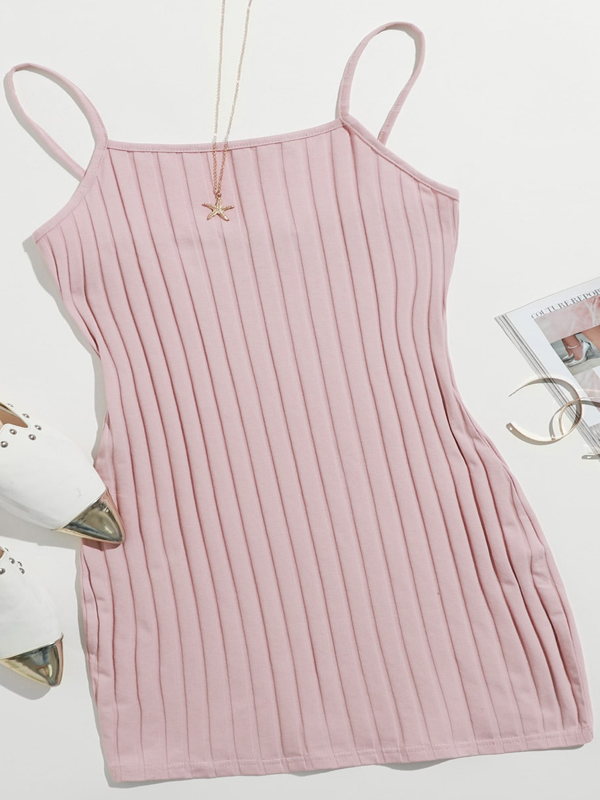

In [35]:
dataset[3]["image"]

In [36]:
dataset[0]["text"]

'A dress with Color: Yellow, Department: Dresses, Detail: Zipper, Fabric-Elasticity: Medium Stretch, Fit: Fitted, Hemline: Pencil, Material: Gabardine, Neckline: Gathered, Pattern: Solid, Sleeve-Length: Sleeveless, Style: Party, Type: Bodycon Skirt, Waistline: Regular'

In [37]:
instruction = "You are a expert fashion stylist and you have deep knowledge about fashion. I run a online fashion store and your task is to generate the captions for the clothes."

def convert_to_conversation(sample):
    conversation = [
        { "role": "user",
          "content" : [
            {"type" : "text",  "text"  : instruction},
            {"type" : "image", "image" : sample["image"]} ]
        },
        { "role" : "assistant",
          "content" : [
            {"type" : "text",  "text"  : sample["text"]} ]
        },
    ]
    return { "messages" : conversation }
pass

Let's convert the dataset into the "correct" format for finetuning(according to [unsloth guide](https://docs.unsloth.ai/basics/vision-fine-tuning) all vision finetuning tasks should be formatted as follows:

In [38]:
converted_dataset = [convert_to_conversation(sample) for sample in dataset]

The first example is now structured like below:

In [39]:
converted_dataset[0]

{'messages': [{'role': 'user',
   'content': [{'type': 'text',
     'text': 'You are a expert fashion stylist and you have deep knowledge about fashion. I run a online fashion store and your task is to generate the captions for the clothes.'},
    {'type': 'image',
     'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=600x800>}]},
  {'role': 'assistant',
   'content': [{'type': 'text',
     'text': 'A dress with Color: Yellow, Department: Dresses, Detail: Zipper, Fabric-Elasticity: Medium Stretch, Fit: Fitted, Hemline: Pencil, Material: Gabardine, Neckline: Gathered, Pattern: Solid, Sleeve-Length: Sleeveless, Style: Party, Type: Bodycon Skirt, Waistline: Regular'}]}]}

### Train

In [40]:
from unsloth import is_bf16_supported
from unsloth.trainer import UnslothVisionDataCollator
from trl import SFTTrainer, SFTConfig

FastVisionModel.for_training(model)

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    data_collator = UnslothVisionDataCollator(model, tokenizer),
    train_dataset = converted_dataset,
    args = SFTConfig(
        per_device_train_batch_size = 2,
        gradient_accumulation_steps = 4,
        warmup_steps = 5,
        max_steps = 40,
        learning_rate = 2e-3,
        fp16 = not is_bf16_supported(),
        bf16 = is_bf16_supported(),
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "outputs",
        report_to = "none",

        remove_unused_columns = False,
        dataset_text_field = "",
        dataset_kwargs = {"skip_prepare_dataset": True},
        dataset_num_proc = 4,
        max_seq_length = 2048,
    ),
)

Unsloth: Model does not have a default image size - using 512


In [41]:
# @title Show current memory stats
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

GPU = Tesla T4. Max memory = 14.741 GB.
8.934 GB of memory reserved.


In [42]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 1,000 | Num Epochs = 1 | Total steps = 40
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 4 x 1) = 8
 "-____-"     Trainable parameters = 40,370,176/7,000,000,000 (0.58% trained)
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


Step,Training Loss
1,5.137900
2,5.170300
3,3.621100
4,2.382800
5,1.598900
6,1.045300
7,0.585800
8,0.612900
9,0.624800
10,0.339200


### Inference

In [43]:
FastVisionModel.for_inference(model) # Enable for inference!

image = dataset[0]["image"]
instruction = "You are a expert fashion stylist and you have deep knowledge about fashion. I run a online fashion store and your task is to generate the captions for the clothes."

messages = [
    {"role": "user", "content": [
        {"type": "image"},
        {"type": "text", "text": instruction}
    ]}
]
input_text = tokenizer.apply_chat_template(messages, add_generation_prompt = True)
inputs = tokenizer(
    image,
    input_text,
    add_special_tokens = False,
    return_tensors = "pt",
).to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer, skip_prompt = True)
_ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 128,
                   use_cache = True, temperature = 1.5, min_p = 0.1)

A dress with Color: Yellow, Department: Dresses, Detail: Zipper, Fabric-Elasticity: Slight Stretch, Fit: Fitted, Hemline: Pencil, Material: Gabardine, Neckline: Slot Collar, Pattern: Solid, Sleeve-Length: Sleeveless, Style: Party, Type: Bodycon Skirt, Waistline: High<|im_end|>


In [44]:
dataset[0]["text"]

'A dress with Color: Yellow, Department: Dresses, Detail: Zipper, Fabric-Elasticity: Medium Stretch, Fit: Fitted, Hemline: Pencil, Material: Gabardine, Neckline: Gathered, Pattern: Solid, Sleeve-Length: Sleeveless, Style: Party, Type: Bodycon Skirt, Waistline: Regular'

<a name="Save"></a>
### Saving, loading finetuned models
To save the final model as LoRA adapters, either use Huggingface's `push_to_hub` for an online save or `save_pretrained` for a local save.

**[NOTE]** This ONLY saves the LoRA adapters, and not the full model. To save to 16bit or GGUF, scroll down!

In [ ]:
model.save_pretrained("fashion_finetuned_qwen-7B")  # Local saving
tokenizer.save_pretrained("fashion_finetuned_qwen-7B")

# Model already pushed
model.push_to_hub("angkul07/fashion_finetuned_qwen-7B", token = "...") # Online saving
tokenizer.push_to_hub("angkul07/fashion_finetuned_qwen-7B", token = "...") # Online saving

Now if you want to load the LoRA adapters we just saved for inference, set `False` to `True`:

In [46]:
from PIL import Image

### Use the fine-tuned model

In [ ]:
if True:
    from unsloth import FastVisionModel
    model, tokenizer = FastVisionModel.from_pretrained(
        model_name = "angkul07/fashion_finetuned_qwen-7B", # YOUR MODEL YOU USED FOR TRAINING
        load_in_4bit = True,
    )
    FastVisionModel.for_inference(model) # Enable for inference!

In [49]:
image = Image.open("/content/fashion.png")
instruction = "You are a expert fashion stylist and you have deep knowledge about fashion. I run a online fashion store and your task is to generate the captions for the clothes."

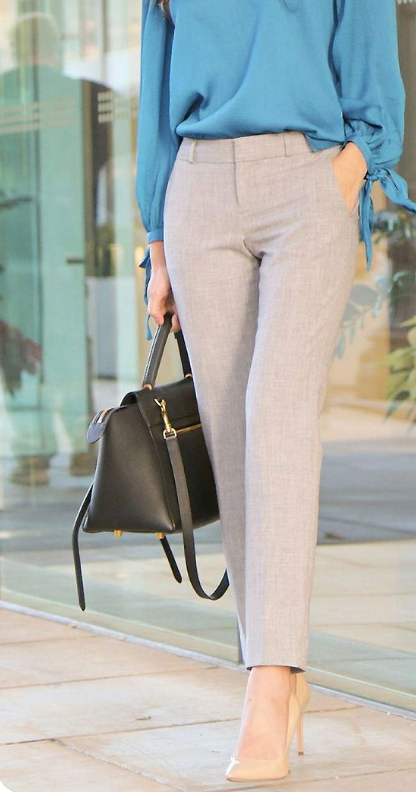

In [50]:
image

In [51]:
messages = [
    {"role": "user", "content": [
        {"type": "image"},
        {"type": "text", "text": instruction}
    ]}
]
input_text = tokenizer.apply_chat_template(messages, add_generation_prompt = True)
inputs = tokenizer(
    image,
    input_text,
    add_special_tokens = False,
    return_tensors = "pt",
).to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer, skip_prompt = True)
_ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 256,
                   use_cache = True, temperature = 1.5, min_p = 0.1)

A dress with Color: Blue, Department: Dresses, Detail: Belted, Fabric-Elasticity: No Sretch, Fit: Fitted, Hemline: Slit, Material: Gabardine, Neckline: Collared, Pattern: Solid, Sleeve-Length: Sleeveless, Style: Elegant, Type: Button Up Shirt, Waistline: High<|im_end|>
